In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
import os 
os.chdir("/content/gdrive/My Drive/BertTweet")

Mounted at /content/gdrive


In [ ]:
import re
import pandas as pd
import glob
path = "Label_geo/*.csv"
file_list = glob.glob(path)
data = pd.DataFrame()
for f in file_list:
  temp = pd.read_csv(f)
  data = pd.concat([data,temp],ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172240 entries, 0 to 172239
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    172240 non-null  int64 
 1   Unnamed: 0.1  172240 non-null  int64 
 2   Tweets        172240 non-null  object
 3   id            172240 non-null  int64 
 4   country       172240 non-null  object
 5   country_code  172240 non-null  object
 6   date          172240 non-null  object
 7   date_freq     172240 non-null  int64 
 8   country_freq  172240 non-null  int64 
 9   target        172240 non-null  object
dtypes: int64(5), object(5)
memory usage: 13.1+ MB


In [ ]:
data.target.value_counts()

positive    90641
neutral     60202
negative    21397
Name: target, dtype: int64

In [ ]:
pos_df = data.loc[data['target']=='positive']
neg_df = data.loc[data['target']=='negative']
neu_df = data.loc[data['target']=='neutral']
pos_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90641 entries, 0 to 172239
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    90641 non-null  int64 
 1   Unnamed: 0.1  90641 non-null  int64 
 2   Tweets        90641 non-null  object
 3   id            90641 non-null  int64 
 4   country       90641 non-null  object
 5   country_code  90641 non-null  object
 6   date          90641 non-null  object
 7   date_freq     90641 non-null  int64 
 8   country_freq  90641 non-null  int64 
 9   target        90641 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words += ['mask', 
               'masks', 
               'face', 
               'facemask', 
               'facemasks', 
               'covid', 
               'covid19', 
               'corona', 
               'coronavirus', 
               'rona', 
               'virus', 
               'viral', 
               'viruses']
eda_stop_words = ['wear', 'wearing', 'get', 'one', 'people',
                  'us', 'like', 'n95', 'go', 'going', 'would', 
                  'surgical', 'via', 'also', 'use', 'even', 'know','rt']
stop_words += eda_stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
twitter_stopwords =   ##
stop_words += twitter_stopwords
stop_words

In [ ]:
neu_sample = neu_df.sample(30000,random_state=2)
neu_sample.info()

In [ ]:
%time
import spacy
nlp = spacy.load("en_core_web_sm")
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)
neu_sample = pd.DataFrame(neu_sample.Tweets.apply(lambda x: lemmatizer(x)))
neu_sample['Tweets'] = neu_sample['Tweets'].str.replace('-PRON-', '')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


In [ ]:
new_sample.head(10)

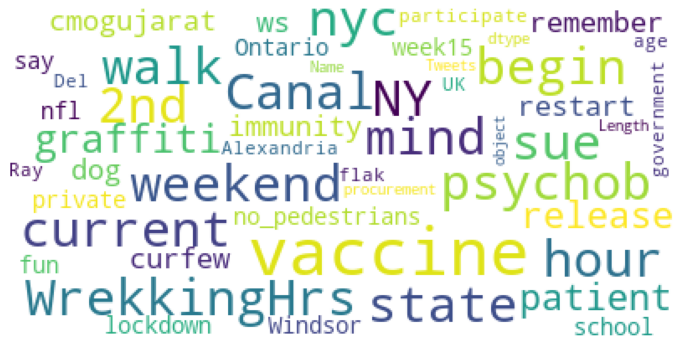

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=300,
                          max_font_size=40, 
                          random_state=100
                         ).generate(str(neu_sample.Tweets))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_top_n_words(corpus, n=None):
  vec = CountVectorizer(stop_words=stop_words).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]
common_words = get_top_n_words(neg_df.Tweets, 10)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count']) 
unigram.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['1000aday', '200aday', '500aday', 'autofollow', 'follow', 'followback', 'followbackk', 'followfriday', 'followgain', 'followme', 'followngain', 'ifollow', 'ifollowback', 'teamautofollow', 'teamfollow', 'teamfollowback'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,unigram,count
0,lockdown,3275
1,pandemic,2624
2,new,2171
3,day,1666
4,stigma,1452
5,quarantine,1430
6,home,1316
7,time,1292
8,amp,1280
9,back,1233


In [ ]:
unigram.to_csv('neg_unigram.csv')

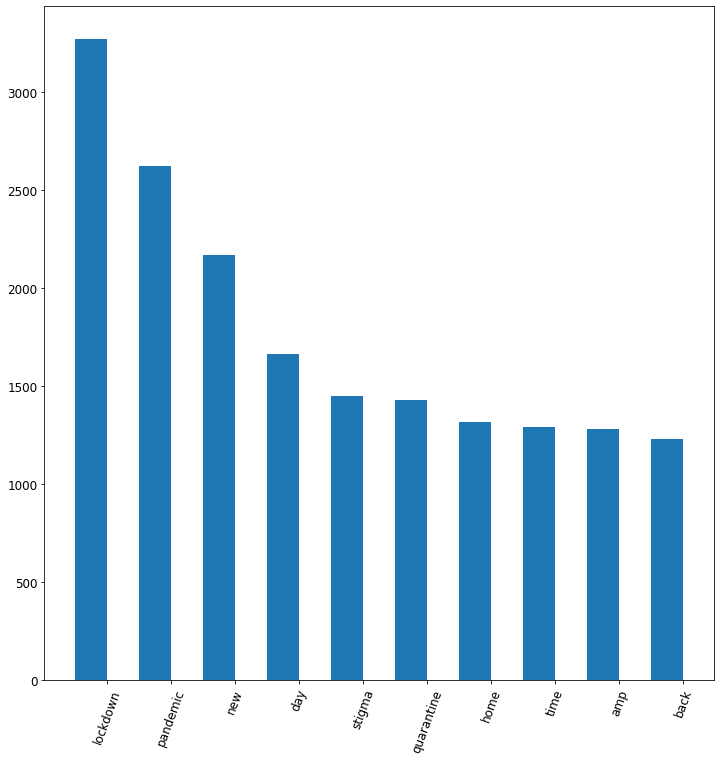

In [ ]:
import numpy as np
indexes = np.arange(len(unigram['unigram']))
width = 0.5
plt.bar(indexes, unigram['count'], width)
plt.xticks(indexes + width * 0.5, unigram['unigram'],rotation=70)
plt.show()

In [ ]:
def get_top_n_trigram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(2,2),stop_words=stop_words).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]
common_words = get_top_n_trigram(neg_df.Tweets, 10)
bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
bigram.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['1000aday', '200aday', '500aday', 'autofollow', 'follow', 'followback', 'followbackk', 'followfriday', 'followgain', 'followme', 'followngain', 'ifollow', 'ifollowback', 'teamautofollow', 'teamfollow', 'teamfollowback'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,bigram,count
0,fighting stigma,1033
1,tear off_calendar,645
2,new york,607
3,social distancing,425
4,google searches,348
5,new cs,346
6,united kingdom,319
7,10 day,303
8,day forecast,301
9,cases double,294


In [ ]:
bigram.to_csv('neg_bigram.csv')

In [ ]:
indexes = np.arange(len(bigram['bigram']))
width = 0.5
plt.bar(indexes, bigram['count'], width)
plt.xticks(indexes + width * 0.5, bigram['bigram'],rotation=50)
plt.show()

In [ ]:
!pip install pyLDAvis
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
data = neg_df

In [ ]:
data = data.Tweets.values.tolist()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations 

data_words = list(sent_to_words(data))
print(data_words[:2])

[['when', 'in', 'rome', 'dark_skin_tone', 'toosoon', 'corona', 'moorpark', 'california'], ['japan', 'japan', 'day', 'forecast', 'of', 'dead', 'this', 'wave', 'may', 'last', 'days', 'and', 'see', 'cases', 'and', 'deaths', 'cases', 'double', 'every', 'days', 'four_o', 'clock', 'covidjapan']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['when', 'in', 'rome', 'dark_skin_tone', 'toosoon', 'corona', 'moorpark', 'california']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out





In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['toosoon']]


In [ ]:
data_lemmatized


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('toosoon', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt


Perplexity:  -11.082712037218036

Coherence Score:  0.4222562494517021


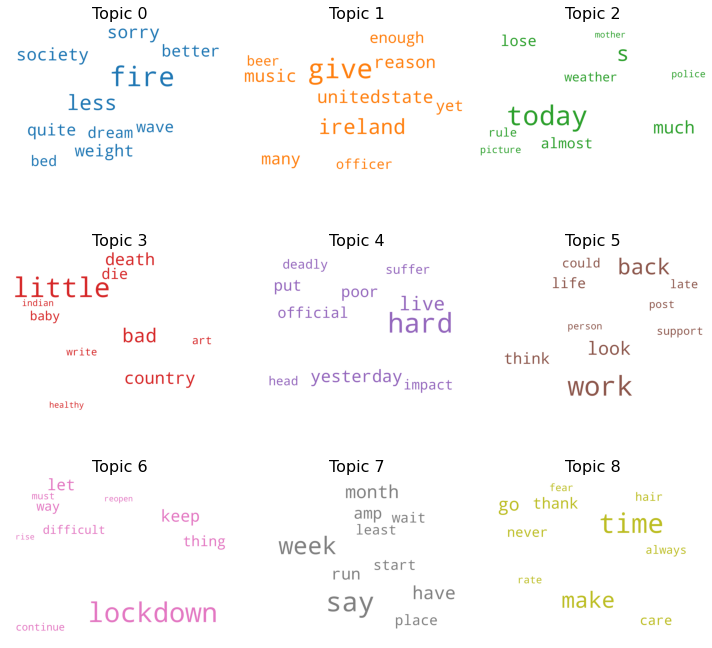

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('negative.png')
plt.show()